In [1]:
import xarray as xr
import numpy as np
import physics # local file with helper functions

%pylab inline
pylab.rcParams['figure.figsize'] = (18.0, 10.0); # Large figures

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os

# gx3v7 output; daily averages
filename = os.path.join(os.path.expanduser('~/'), 'MARBL_data', 'POP_hist.nc')
if not os.path.isfile(filename):
    casename='g.e21.G1850ECO.T62_g17.gen_single_col'
    rundir=os.path.join(os.path.sep, 'glade', 'scratch', 'mlevy', casename, 'run')
    date='0001-01'
    filename = os.path.join(rundir, '%s.pop.h.%s.nc' % (casename, date))

if os.path.isfile(filename):
    print("Opening %s" % filename)
    ds = xr.open_dataset(filename, decode_times=False, decode_coords=False)
else:
    print("Can not find %s" % filename)

Opening /Users/mlevy/MARBL_data/POP_hist.nc


In [3]:
# Variables to keep (POP Variable Names)
grid_vars = ['TLAT', 'TLONG', 'z_t', 'z_t_150m', 'z_w_bot', 'dz']
forcing_vars = ['ECOSYS_XKW', 'ATM_FINE_DUST_FLUX_CPL', 'ATM_COARSE_DUST_FLUX_CPL', 
                'SEAICE_DUST_FLUX_CPL', 'TEMP', 'SALT', 'ECOSYS_ATM_PRESS', 'FESEDFLUX',
                'ECOSYS_IFRAC', 'IRON_FLUX', 'NOx_FLUX', 'NHy_FLUX', 'ATM_CO2', 'ATM_ALT_CO2']
base_tracers = ['PO4', 'NO3', 'SiO3', 'NH4', 'Fe', 'Lig', 'O2', 'DIC', 'DIC_ALT_CO2', 'ALK', 'ALK_ALT_CO2',
                'DOC', 'DON', 'DOP', 'DOPr', 'DONr', 'DOCr', 'zooC', 'spChl', 'spC', 'spP', 'spFe', 'spCaCO3',
                'diatChl', 'diatC', 'diatP', 'diatFe', 'diatSi', 'diazChl', 'diazC', 'diazP', 'diazFe']
ciso_tracers = ['DI13C', 'DO13C', 'DI14C', 'DO14C', 'zoo13C', 'zoo14C', 'sp14C', 'sp14C',
                'spCa13CO3', 'spCa14CO3', 'diat13C', 'diat14c', 'diaz13C', 'diaz14C']
# For MCOG_vars, need to determine number of bins
MCOG_vars = []
nbins = len([v for v in ds.variables if v.startswith('FRACR_BIN_')])
for n in range(0,nbins):
    for varname in ['FRACR_BIN', 'QSW_BIN']:
        MCOG_vars.append('{}_{:02d}'.format(varname, n+1))

vars_to_keep = grid_vars + forcing_vars + base_tracers + ciso_tracers + MCOG_vars
# Pick a (lat, lon)
# gx3v7
# (17,18) is Southern Ocean (28.1 E, 50.576 S); has 56 levels
# (19,50) is near SOFS site SW of Tasmania (143.3 E, 45.695 S); has 54 levels
# ---
# gx1v7
# (53, 60) is Southern Ocean (28.1 E, 50.907 S); has 58 levels
# (63, 163) is near SOFS site SW of Tasmania (143.9 E, 45.564 S); has 55 levels

lat_in = 53
lon_in = 60

lon = ds.isel(time=0, nlat=lat_in, nlon=lon_in)['TLONG'].values
lat = ds.isel(time=0, nlat=lat_in, nlon=lon_in)['TLAT'].values
depth_cnt = ds.isel(time=0, nlat=lat_in, nlon=lon_in)['KMT'].values

# Verify location
print('(lon, lat) = ({:.1f}, {:.3f})'.format(lon, lat))
print('There are {} levels'.format(depth_cnt))

# Set up separate data sets for forcing and initial conditions
#forcing_col = raw_data.copy(deep=True)
#forcing_col.drop([v for v in raw_data.variables if v not in grid_vars + forcing_vars])

(lon, lat) = (28.1, -50.907)
There are 55.0 levels


In [4]:
# Reduce data
raw_data = ds.isel(time=0, nlat=lat_in, nlon=lon_in).drop([v for v in ds.variables if v not in vars_to_keep])

for var_name in raw_data.variables:
    if 'coordinates' in raw_data[var_name].attrs:
        del(raw_data[var_name].attrs['coordinates'])

raw_data.to_netcdf('raw_data.nc')

In [5]:
# Variables to keep (MARBL variable names)
grid_vars_to_MARBL = {'lat': 'TLAT', 'lon' : 'TLONG', 'z_t' : 'z_t', 'z_w_bot' : 'z_w_bot', 'delta_z' : 'dz'}
forcing_vars_to_MARBL = {'temperature' : 'TEMP', 'salinity' : 'SALT', 'atm_pressure' : 'ECOSYS_ATM_PRESS',
                         'ice_frac' : 'ECOSYS_IFRAC', 'iron_flux' : 'IRON_FLUX', 'nox_flux' : 'NOx_FLUX', 'nhy_flux' : 'NHy_FLUX',
                         'atm_co2' : 'ATM_CO2', 'atm_alt_co2' : 'ATM_CO2'}
tracers_MARBL = base_tracers + ciso_tracers

MARBL_data = raw_data.copy(deep=True).drop(raw_data.variables)
for MARBL_name, POP_name in grid_vars_to_MARBL.items():
    MARBL_data[MARBL_name] = raw_data[POP_name]
for MARBL_name, POP_name in forcing_vars_to_MARBL.items():
    MARBL_data[MARBL_name] = raw_data[POP_name]

# Define all MARBL_data variables prior to populating
# Metadata will be overwritten, so use ECOSYS_IFRAC for 2D vars
# and TEMP for 3D vars
MARBL_data['u10_sqr'] = raw_data['ECOSYS_IFRAC']
MARBL_data['pressure'] = raw_data['TEMP']

# unit conversion
# cm to m
for varname in ['z_t', 'z_w_bot', 'delta_z']:
    MARBL_data[varname].values = raw_data[grid_vars_to_MARBL[varname]].values*0.01
    MARBL_data[varname].attrs['units'] = 'm'

# nmol/cm^2/s to mmol/m^2/s
for varname in ['nox_flux', 'nhy_flux']:
    MARBL_data[varname].values = raw_data[forcing_vars_to_MARBL[varname]].values*0.01
    MARBL_data[varname].attrs['units'] = 'mmol/m^2/s'

# salinity units should be psu
MARBL_data['salinity'].attrs['units'] = 'psu'

# Add SST, SSS, u10_sqr and pressure to dataset
MARBL_data['SST'] = physics.get_surface_value(MARBL_data, 'temperature')
MARBL_data['SSS'] = physics.get_surface_value(MARBL_data, 'salinity')

# u10_sqr
varname = 'u10_sqr'
# first just populate it with ECOSYS_XKW (another scalar) to get all metadata
MARBL_data[varname].values = physics.xkw_to_u10sqr(raw_data['ECOSYS_XKW'].values)
MARBL_data[varname].attrs['long_name'] = '10m wind speed squared'
MARBL_data[varname].attrs['units'] = 'm^2/s^2'

# pressure
varname = 'pressure'
# first just populate it with TEMP (another 1D var) to get all metadata
MARBL_data[varname].values = np.where(np.isnan(raw_data['TEMP'].values),
                                      np.nan,
                                      physics.depth_to_pressure(MARBL_data['z_t'].values))
MARBL_data[varname].attrs['long_name'] = 'Pressure'
MARBL_data[varname].attrs['units'] = 'bars'
FRACR_array = np.empty(nbins)
QSW_array = np.empty(nbins)
for n in range(0,nbins):
    FRACR_array[n] = raw_data['FRACR_BIN_{:02d}'.format(n+1)].values
    QSW_array[n] = raw_data['QSW_BIN_{:02d}'.format(n+1)].values
# Combine MCOG bin data into single variable
#MCOG_ds = xr.Dataset({'FRACR_BIN': ('nbin', FRACR_array), 'QSW_BIN': ('nbin', QSW_array)})
MARBL_data['FRACR_BIN'] = xr.DataArray(FRACR_array, dims='nbin')
MARBL_data['QSW_BIN'] = xr.DataArray(QSW_array, dims='nbin')

# dust flux is sum of atm fine dust, atm coarse dust, and seaice dust fluxes
varname = 'dust_flux'
MARBL_data[varname] = raw_data['ATM_FINE_DUST_FLUX_CPL'] + raw_data['ATM_COARSE_DUST_FLUX_CPL'] + \
                          raw_data['SEAICE_DUST_FLUX_CPL']
MARBL_data[varname].attrs = raw_data['ATM_FINE_DUST_FLUX_CPL'].attrs
MARBL_data[varname].attrs['long_name'] = 'Dust Flux'
# convert to kg/m^2/s
MARBL_data[varname].values = MARBL_data[varname].values*10.
MARBL_data[varname].attrs['units'] = 'kg/m^2/s'

MARBL_data.rename({'z_t' : 'zt', 'z_w_bot' : 'zw'}, inplace=True)
MARBL_data.to_netcdf('marbl.nc')

In [6]:
def update_xlim(interior_forcing):
    if interior_forcing == 'tmperature':
        plt.xlim(0, 13)
    if interior_forcing == 'salinity':
        plt.xlim(34, 35)
    if interior_forcing == 'pressure':
        plt.xlim(0,400)

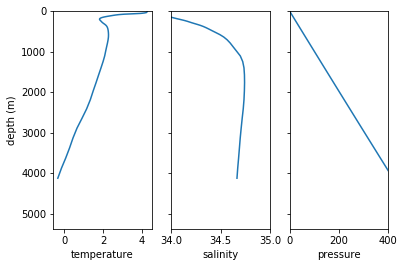

In [7]:
fig, axes = plt.subplots(ncols=3)
plt.xlim(400000,0)

for n, interior_forcing in enumerate(['temperature', 'salinity', 'pressure']):
    MARBL_data[interior_forcing].plot(ax=axes[n])
    plt.subplot(1,3,n+1);
    plt.plot(MARBL_data[interior_forcing].values, MARBL_data['zt'].values);
    plt.ylim(max(MARBL_data['zt'].values), min(MARBL_data['zt'].values));
    plt.xlabel(interior_forcing)
    # Only want y-axis label and tick labels on left-most plot
    plt.ylabel("depth (m)" if (n == 0) else "")
    plt.tick_params(labelleft=(n == 0))
        
    update_xlim(interior_forcing);